In [98]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [99]:
from tensorflow.keras import regularizers

In [100]:
import os

In [101]:
mylist = os.listdir('RawData/')

In [102]:
type(mylist)

list

In [103]:
print(mylist[1800])

sa01 (2).wav


In [104]:
print(mylist[400][6:-16])

03


# Plotting the Audio file's waveform and its spectogram

In [105]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

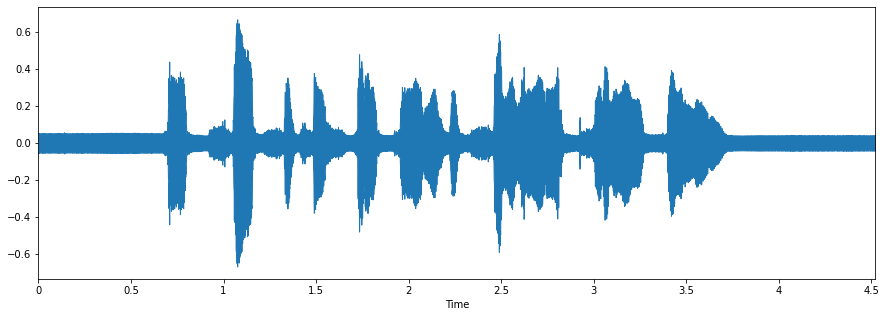

In [106]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

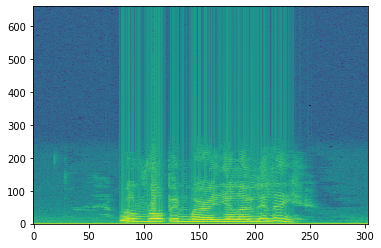

In [107]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

# Setting the labels

In [157]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
     #   feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [158]:
labels = pd.DataFrame(feeling_list)

In [159]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


# Getting the features of audio files using librosa

In [160]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        [float(i) for i in feature]
        feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [161]:
df[:5]

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."


In [162]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [163]:
newdf = pd.concat([df3,labels], axis=1)

In [164]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [165]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.144051,-48.705654,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.323643,-40.710770,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001244,-43.610100,-44.698246,female_calm
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.383774,-43.965401,male_calm


In [166]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
461,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,...,-64.586044,-64.523933,-64.174210,-66.311821,-63.141411,-60.602013,-63.572910,-64.221634,-63.324245,female_sad
715,-40.891319,-40.685875,-40.556316,-40.733379,-40.456841,-40.096493,-40.340744,-40.320309,-40.264194,-40.394737,...,-30.764467,-31.949348,-31.466230,-32.110970,-32.843441,-32.051674,-30.832907,-18.822792,-13.640904,female_angry
463,-57.377068,-55.364803,-51.757774,-51.642071,-50.936546,-53.281269,-53.649372,-53.964397,-56.714439,-57.512039,...,-53.272255,-52.861198,-52.425888,-52.243771,-53.530228,-52.977940,-51.750202,-52.356892,-55.265888,female_sad
453,-59.711548,-57.312229,-55.660591,-55.990540,-57.889084,-57.380047,-56.130924,-55.971897,-56.685165,-54.990089,...,-49.885990,-50.502590,-51.092934,-50.914997,-51.973625,-51.381207,-52.028259,-52.962822,-56.263798,female_sad
689,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,...,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,-39.442009,female_angry
1113,3.595598,1.083096,-3.667537,-4.297880,-3.220630,-1.137925,-1.920118,-2.925378,-3.896494,-5.306397,...,-25.300869,-23.739408,-24.535179,-26.205332,-25.597141,-24.293079,-25.012482,-24.546999,-22.429348,male_happy
97,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,-61.444542,...,-40.101921,-40.022526,-39.160404,-39.792961,-40.519104,-40.453396,-39.562027,-31.444233,-26.050508,female_calm
886,-52.988201,-53.102032,-53.116905,-53.790546,-54.014877,-54.485970,-54.411587,-54.115250,-52.942505,-52.026791,...,-53.352226,-54.098373,-53.875473,-54.247341,-54.239582,-53.348457,-53.820827,-54.235146,-54.240383,male_fearful
373,-49.293987,-49.293987,-49.293987,-49.293987,-49.293987,-49.293987,-49.901516,-47.674557,-47.494473,-48.012447,...,-48.483341,-47.690678,-47.637386,-48.026482,-46.827877,-46.361958,-47.048222,-46.011452,-46.312950,female_happy
868,-46.822250,-47.160557,-46.677490,-46.768761,-46.882095,-47.581417,-45.960087,-45.217400,-45.414577,-44.641495,...,-49.930172,-50.347759,-50.347759,-50.160732,-49.922913,-50.347759,-50.347759,-50.347759,-50.347759,male_fearful


In [167]:
rnewdf=rnewdf.fillna(0)

# Dividing the data into test and train

In [168]:
newdf1 = np.random.rand(len(rnewdf)) < 0.9
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [169]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
52,-63.509117,-63.633816,-63.504391,-63.299419,-63.838966,-65.177299,-66.479500,-65.160194,-65.833740,-64.724403,...,-40.389946,-36.990444,-38.102467,-40.782673,-40.174316,-40.962994,-43.929958,-43.562035,-41.383224,male_calm
1136,0.611285,-1.252866,-4.039234,-2.989265,-4.940776,-9.884520,-16.402344,-19.185650,-19.758821,-20.413073,...,-11.109084,-14.450968,-15.750225,-18.861238,-14.507909,-7.715653,-6.120901,-5.397735,-3.831895,male_happy
12,-63.131767,-61.888165,-59.611084,-57.938656,-61.089252,-60.685398,-62.597221,-68.623726,-69.007233,-66.853775,...,-63.206009,-60.798763,-60.709068,-56.783298,-55.975407,-61.550983,-63.805748,-60.823490,-57.963692,male_calm
210,-56.569057,-59.373470,-61.183983,-58.684711,-59.174419,-58.193954,-58.287373,-58.266476,-58.675419,-57.727295,...,-44.373081,-43.040306,-43.771442,-45.011253,-48.073418,-49.771999,-49.812584,-50.470100,-57.511478,male_happy
648,-53.913982,-53.856716,-53.552776,-53.879398,-54.017361,-54.070801,-54.128792,-54.258133,-54.262688,-54.137371,...,-41.416878,-41.197632,-45.481136,-47.965393,-49.700516,-52.673828,-52.024986,-51.075668,-52.622616,male_angry
219,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,...,-56.310959,-57.144508,-57.759190,-56.183907,-56.088951,-57.717632,-58.577389,-58.642826,-58.262722,female_happy
1166,-25.907646,-25.869795,-27.495556,-26.596586,-26.451052,-26.436209,-26.418201,-24.776852,-24.386250,-24.525984,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_sad
980,-6.275177,-9.108636,-10.083969,-6.191623,-4.065371,-5.395507,-5.659694,-3.885976,-4.369981,-5.827116,...,-4.408275,-4.782111,-4.142441,-4.102316,-4.897834,-4.741646,-5.246380,-3.289782,-1.432821,male_angry
935,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,...,-45.666245,-45.259193,-45.147652,-45.233620,-45.194878,-45.194878,-45.194878,-45.194878,-45.194878,female_fearful
171,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,-66.224579,...,-36.320461,-36.561989,-36.246010,-35.017441,-35.637676,-36.790985,-39.443550,-33.025143,-26.604511,female_calm


In [170]:
trainfeatures = train.iloc[:, :-1]

In [171]:
trainlabel = train.iloc[:, -1:]

In [172]:
testfeatures = test.iloc[:, :-1]

In [173]:
testlabel = test.iloc[:, -1:]

In [174]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

c:\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [175]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [176]:
X_train.shape

(1068, 216)

# Changing dimension for CNN Model

In [177]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [178]:
from tensorflow import keras
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

c:\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [179]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_24 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_25 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 27, 128)          

In [180]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [181]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
67/67 [==============================] - 4s 44ms/step - loss: 2.3783 - accuracy: 0.1189 - val_loss: 2.2674 - val_accuracy: 0.1515
Epoch 2/700
67/67 [==============================] - 3s 41ms/step - loss: 2.3035 - accuracy: 0.1376 - val_loss: 2.2551 - val_accuracy: 0.1439
Epoch 3/700
67/67 [==============================] - 3s 41ms/step - loss: 2.2853 - accuracy: 0.1264 - val_loss: 2.2430 - val_accuracy: 0.1742
Epoch 4/700
67/67 [==============================] - 3s 48ms/step - loss: 2.2464 - accuracy: 0.1779 - val_loss: 2.2176 - val_accuracy: 0.1894
Epoch 5/700
67/67 [==============================] - 3s 49ms/step - loss: 2.2343 - accuracy: 0.1667 - val_loss: 2.1991 - val_accuracy: 0.2045
Epoch 6/700
67/67 [==============================] - 3s 43ms/step - loss: 2.2090 - accuracy: 0.1788 - val_loss: 2.1855 - val_accuracy: 0.2348
Epoch 7/700
67/67 [==============================] - 3s 43ms/step - loss: 2.2055 - accuracy: 0.1826 - val_loss: 2.1586 - val_accuracy: 0.1970
Epoch 

67/67 [==============================] - 3s 45ms/step - loss: 1.4802 - accuracy: 0.4345 - val_loss: 1.5202 - val_accuracy: 0.3712
Epoch 59/700
67/67 [==============================] - 3s 45ms/step - loss: 1.4821 - accuracy: 0.4232 - val_loss: 1.5258 - val_accuracy: 0.3712
Epoch 60/700
67/67 [==============================] - 3s 48ms/step - loss: 1.4594 - accuracy: 0.4251 - val_loss: 1.5175 - val_accuracy: 0.3561
Epoch 61/700
67/67 [==============================] - 3s 48ms/step - loss: 1.4618 - accuracy: 0.4410 - val_loss: 1.5282 - val_accuracy: 0.3636
Epoch 62/700
67/67 [==============================] - 3s 44ms/step - loss: 1.4572 - accuracy: 0.4438 - val_loss: 1.5344 - val_accuracy: 0.3409
Epoch 63/700
67/67 [==============================] - 3s 44ms/step - loss: 1.4434 - accuracy: 0.4363 - val_loss: 1.5172 - val_accuracy: 0.3561
Epoch 64/700
67/67 [==============================] - 3s 44ms/step - loss: 1.4488 - accuracy: 0.4438 - val_loss: 1.5165 - val_accuracy: 0.3636
Epoch 65/700

67/67 [==============================] - 3s 47ms/step - loss: 1.2226 - accuracy: 0.5496 - val_loss: 1.4550 - val_accuracy: 0.4167
Epoch 116/700
67/67 [==============================] - 3s 45ms/step - loss: 1.2178 - accuracy: 0.5496 - val_loss: 1.4715 - val_accuracy: 0.4091
Epoch 117/700
67/67 [==============================] - 3s 44ms/step - loss: 1.2005 - accuracy: 0.5609 - val_loss: 1.4462 - val_accuracy: 0.4242
Epoch 118/700
67/67 [==============================] - 3s 46ms/step - loss: 1.1963 - accuracy: 0.5552 - val_loss: 1.4818 - val_accuracy: 0.4015
Epoch 119/700
67/67 [==============================] - 3s 44ms/step - loss: 1.2026 - accuracy: 0.5571 - val_loss: 1.4381 - val_accuracy: 0.4091
Epoch 120/700
67/67 [==============================] - 3s 49ms/step - loss: 1.2087 - accuracy: 0.5449 - val_loss: 1.4420 - val_accuracy: 0.4091
Epoch 121/700
67/67 [==============================] - 3s 46ms/step - loss: 1.2071 - accuracy: 0.5440 - val_loss: 1.4304 - val_accuracy: 0.4091
Epoch 

Epoch 172/700
67/67 [==============================] - 4s 52ms/step - loss: 1.0221 - accuracy: 0.6255 - val_loss: 1.4568 - val_accuracy: 0.4394
Epoch 173/700
67/67 [==============================] - 3s 49ms/step - loss: 1.0261 - accuracy: 0.6311 - val_loss: 1.4803 - val_accuracy: 0.4394
Epoch 174/700
67/67 [==============================] - 3s 50ms/step - loss: 1.0222 - accuracy: 0.6292 - val_loss: 1.4485 - val_accuracy: 0.4848
Epoch 175/700
67/67 [==============================] - 3s 51ms/step - loss: 1.0191 - accuracy: 0.6358 - val_loss: 1.4515 - val_accuracy: 0.4545
Epoch 176/700
67/67 [==============================] - 3s 46ms/step - loss: 1.0194 - accuracy: 0.6320 - val_loss: 1.4413 - val_accuracy: 0.4621
Epoch 177/700
67/67 [==============================] - 4s 52ms/step - loss: 1.0212 - accuracy: 0.6320 - val_loss: 1.4344 - val_accuracy: 0.4545
Epoch 178/700
67/67 [==============================] - 3s 44ms/step - loss: 1.0275 - accuracy: 0.6358 - val_loss: 1.4491 - val_accuracy:

Epoch 229/700
67/67 [==============================] - 4s 63ms/step - loss: 0.8738 - accuracy: 0.7032 - val_loss: 1.4813 - val_accuracy: 0.4470
Epoch 230/700
67/67 [==============================] - 4s 62ms/step - loss: 0.8694 - accuracy: 0.6948 - val_loss: 1.4917 - val_accuracy: 0.4470
Epoch 231/700
67/67 [==============================] - 4s 62ms/step - loss: 0.8557 - accuracy: 0.7022 - val_loss: 1.5106 - val_accuracy: 0.4848
Epoch 232/700
67/67 [==============================] - 4s 63ms/step - loss: 0.8482 - accuracy: 0.7022 - val_loss: 1.4605 - val_accuracy: 0.4621
Epoch 233/700
67/67 [==============================] - 4s 63ms/step - loss: 0.8605 - accuracy: 0.6919 - val_loss: 1.4699 - val_accuracy: 0.4470
Epoch 234/700
67/67 [==============================] - 4s 63ms/step - loss: 0.8561 - accuracy: 0.6835 - val_loss: 1.4730 - val_accuracy: 0.4545
Epoch 235/700
67/67 [==============================] - 4s 63ms/step - loss: 0.8307 - accuracy: 0.7163 - val_loss: 1.4719 - val_accuracy:

Epoch 286/700
67/67 [==============================] - 3s 44ms/step - loss: 0.7243 - accuracy: 0.7556 - val_loss: 1.4864 - val_accuracy: 0.4848
Epoch 287/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7235 - accuracy: 0.7350 - val_loss: 1.5035 - val_accuracy: 0.4621
Epoch 288/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7069 - accuracy: 0.7388 - val_loss: 1.4772 - val_accuracy: 0.4697
Epoch 289/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7129 - accuracy: 0.7519 - val_loss: 1.5113 - val_accuracy: 0.4394
Epoch 290/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7104 - accuracy: 0.7463 - val_loss: 1.5664 - val_accuracy: 0.4318
Epoch 291/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7414 - accuracy: 0.7247 - val_loss: 1.4793 - val_accuracy: 0.4848
Epoch 292/700
67/67 [==============================] - 3s 43ms/step - loss: 0.7038 - accuracy: 0.7584 - val_loss: 1.4956 - val_accuracy:

Epoch 343/700
67/67 [==============================] - 3s 48ms/step - loss: 0.5990 - accuracy: 0.8006 - val_loss: 1.5501 - val_accuracy: 0.4545
Epoch 344/700
67/67 [==============================] - 3s 47ms/step - loss: 0.5749 - accuracy: 0.8034 - val_loss: 1.6126 - val_accuracy: 0.4621
Epoch 345/700
67/67 [==============================] - 3s 47ms/step - loss: 0.5994 - accuracy: 0.7949 - val_loss: 1.5636 - val_accuracy: 0.4621
Epoch 346/700
67/67 [==============================] - 3s 47ms/step - loss: 0.6052 - accuracy: 0.7968 - val_loss: 1.5204 - val_accuracy: 0.5000
Epoch 347/700
67/67 [==============================] - 3s 47ms/step - loss: 0.5901 - accuracy: 0.7968 - val_loss: 1.5471 - val_accuracy: 0.4773
Epoch 348/700
67/67 [==============================] - 3s 47ms/step - loss: 0.5876 - accuracy: 0.8006 - val_loss: 1.5629 - val_accuracy: 0.4697
Epoch 349/700
67/67 [==============================] - 3s 47ms/step - loss: 0.5977 - accuracy: 0.7978 - val_loss: 1.5406 - val_accuracy:

67/67 [==============================] - 5s 69ms/step - loss: 0.4643 - accuracy: 0.8455 - val_loss: 1.6072 - val_accuracy: 0.4773
Epoch 400/700
67/67 [==============================] - 4s 60ms/step - loss: 0.4687 - accuracy: 0.8446 - val_loss: 1.6562 - val_accuracy: 0.4924
Epoch 401/700
67/67 [==============================] - 3s 48ms/step - loss: 0.4472 - accuracy: 0.8567 - val_loss: 1.6265 - val_accuracy: 0.4773
Epoch 402/700
67/67 [==============================] - 3s 47ms/step - loss: 0.4605 - accuracy: 0.8502 - val_loss: 1.6491 - val_accuracy: 0.4394
Epoch 403/700
67/67 [==============================] - 3s 47ms/step - loss: 0.4645 - accuracy: 0.8474 - val_loss: 1.6467 - val_accuracy: 0.5152
Epoch 404/700
67/67 [==============================] - 3s 51ms/step - loss: 0.4512 - accuracy: 0.8558 - val_loss: 1.6244 - val_accuracy: 0.4697
Epoch 405/700
67/67 [==============================] - 3s 49ms/step - loss: 0.4618 - accuracy: 0.8436 - val_loss: 1.6512 - val_accuracy: 0.5000
Epoch 

Epoch 456/700
67/67 [==============================] - 4s 66ms/step - loss: 0.3614 - accuracy: 0.8876 - val_loss: 1.7642 - val_accuracy: 0.4848
Epoch 457/700
67/67 [==============================] - 4s 55ms/step - loss: 0.3377 - accuracy: 0.8904 - val_loss: 1.7591 - val_accuracy: 0.5227
Epoch 458/700
67/67 [==============================] - 3s 50ms/step - loss: 0.3451 - accuracy: 0.8970 - val_loss: 1.7350 - val_accuracy: 0.4697
Epoch 459/700
67/67 [==============================] - 4s 54ms/step - loss: 0.3593 - accuracy: 0.8764 - val_loss: 1.7563 - val_accuracy: 0.5000
Epoch 460/700
67/67 [==============================] - 4s 61ms/step - loss: 0.3492 - accuracy: 0.8895 - val_loss: 1.7175 - val_accuracy: 0.4773
Epoch 461/700
67/67 [==============================] - 4s 62ms/step - loss: 0.3437 - accuracy: 0.8839 - val_loss: 1.7809 - val_accuracy: 0.4924
Epoch 462/700
67/67 [==============================] - 3s 47ms/step - loss: 0.3521 - accuracy: 0.8867 - val_loss: 1.7574 - val_accuracy:

Epoch 513/700
67/67 [==============================] - 3s 47ms/step - loss: 0.2479 - accuracy: 0.9251 - val_loss: 1.8753 - val_accuracy: 0.5000
Epoch 514/700
67/67 [==============================] - 3s 47ms/step - loss: 0.2662 - accuracy: 0.9139 - val_loss: 1.8587 - val_accuracy: 0.5076
Epoch 515/700
67/67 [==============================] - 3s 47ms/step - loss: 0.2496 - accuracy: 0.9288 - val_loss: 1.8606 - val_accuracy: 0.5000
Epoch 516/700
67/67 [==============================] - 3s 50ms/step - loss: 0.2548 - accuracy: 0.9185 - val_loss: 1.8494 - val_accuracy: 0.5152
Epoch 517/700
67/67 [==============================] - 4s 54ms/step - loss: 0.2670 - accuracy: 0.9204 - val_loss: 1.8257 - val_accuracy: 0.4848
Epoch 518/700
67/67 [==============================] - 3s 49ms/step - loss: 0.2553 - accuracy: 0.9167 - val_loss: 1.8443 - val_accuracy: 0.5303
Epoch 519/700
67/67 [==============================] - 3s 51ms/step - loss: 0.2501 - accuracy: 0.9260 - val_loss: 1.9087 - val_accuracy:

Epoch 570/700
67/67 [==============================] - 3s 46ms/step - loss: 0.1740 - accuracy: 0.9597 - val_loss: 2.0128 - val_accuracy: 0.5455
Epoch 571/700
67/67 [==============================] - 4s 56ms/step - loss: 0.1886 - accuracy: 0.9466 - val_loss: 2.0043 - val_accuracy: 0.5227
Epoch 572/700
67/67 [==============================] - 4s 53ms/step - loss: 0.1751 - accuracy: 0.9513 - val_loss: 1.9814 - val_accuracy: 0.5152
Epoch 573/700
67/67 [==============================] - 4s 58ms/step - loss: 0.1843 - accuracy: 0.9485 - val_loss: 2.0394 - val_accuracy: 0.4848
Epoch 574/700
67/67 [==============================] - 4s 56ms/step - loss: 0.1770 - accuracy: 0.9504 - val_loss: 2.0072 - val_accuracy: 0.4924
Epoch 575/700
67/67 [==============================] - 4s 57ms/step - loss: 0.1709 - accuracy: 0.9532 - val_loss: 2.0257 - val_accuracy: 0.5227
Epoch 576/700
67/67 [==============================] - 4s 61ms/step - loss: 0.1751 - accuracy: 0.9485 - val_loss: 2.0093 - val_accuracy:

Epoch 627/700
67/67 [==============================] - 4s 57ms/step - loss: 0.1209 - accuracy: 0.9672 - val_loss: 2.1388 - val_accuracy: 0.5303
Epoch 628/700
67/67 [==============================] - 4s 53ms/step - loss: 0.1245 - accuracy: 0.9691 - val_loss: 2.1169 - val_accuracy: 0.5076
Epoch 629/700
67/67 [==============================] - 4s 56ms/step - loss: 0.1399 - accuracy: 0.9607 - val_loss: 2.2005 - val_accuracy: 0.5227
Epoch 630/700
67/67 [==============================] - 4s 58ms/step - loss: 0.1274 - accuracy: 0.9672 - val_loss: 2.1396 - val_accuracy: 0.5076
Epoch 631/700
67/67 [==============================] - 4s 57ms/step - loss: 0.1283 - accuracy: 0.9700 - val_loss: 2.2259 - val_accuracy: 0.4848
Epoch 632/700
67/67 [==============================] - 4s 56ms/step - loss: 0.1288 - accuracy: 0.9654 - val_loss: 2.1404 - val_accuracy: 0.5152
Epoch 633/700
67/67 [==============================] - 4s 57ms/step - loss: 0.1347 - accuracy: 0.9625 - val_loss: 2.1387 - val_accuracy:

67/67 [==============================] - 4s 65ms/step - loss: 0.0861 - accuracy: 0.9757 - val_loss: 2.3387 - val_accuracy: 0.5076
Epoch 684/700
67/67 [==============================] - 5s 68ms/step - loss: 0.0860 - accuracy: 0.9766 - val_loss: 2.3830 - val_accuracy: 0.5152
Epoch 685/700
67/67 [==============================] - 4s 65ms/step - loss: 0.0902 - accuracy: 0.9710 - val_loss: 2.3373 - val_accuracy: 0.5227
Epoch 686/700
67/67 [==============================] - 3s 52ms/step - loss: 0.0865 - accuracy: 0.9785 - val_loss: 2.3515 - val_accuracy: 0.5152
Epoch 687/700
67/67 [==============================] - 3s 47ms/step - loss: 0.0811 - accuracy: 0.9822 - val_loss: 2.3476 - val_accuracy: 0.4848
Epoch 688/700
67/67 [==============================] - 3s 48ms/step - loss: 0.0873 - accuracy: 0.9757 - val_loss: 2.3731 - val_accuracy: 0.5152
Epoch 689/700
67/67 [==============================] - 4s 56ms/step - loss: 0.0839 - accuracy: 0.9813 - val_loss: 2.3245 - val_accuracy: 0.5000
Epoch 

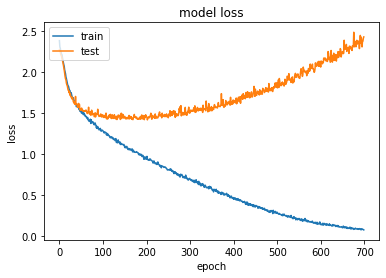

In [183]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [184]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\Jupyter_Codes\Emotion Sensor\saved_models\Emotion_Voice_Detection_Model.h5 


In [185]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [186]:
# loading json and creating model
from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 50.76%


In [187]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

5/5 [==============================] - 0s 15ms/step


In [188]:
preds

array([[7.6573037e-02, 1.3010172e-08, 8.9958447e-01, ..., 4.0785184e-05,
        3.5818104e-08, 4.1194944e-08],
       [4.8915231e-06, 4.5900614e-14, 9.9871290e-01, ..., 7.6305398e-09,
        1.8738014e-15, 1.4126261e-12],
       [1.2761021e-08, 2.4948529e-27, 5.3096467e-18, ..., 5.7366033e-05,
        5.0188688e-04, 9.9943346e-01],
       ...,
       [1.0846386e-08, 7.9133810e-16, 3.6778943e-13, ..., 1.2611908e-02,
        8.6224434e-05, 9.8729998e-01],
       [2.5201056e-04, 3.0242191e-23, 7.8563653e-13, ..., 1.7854409e-05,
        9.7412580e-05, 2.0890966e-05],
       [1.1073171e-06, 9.9294782e-01, 4.0739245e-04, ..., 3.5286594e-05,
        2.9431956e-03, 3.3698328e-05]], dtype=float32)

In [189]:
preds1=preds.argmax(axis=1)

In [190]:
preds1


array([2, 2, 9, 3, 5, 0, 0, 5, 7, 0, 6, 8, 6, 4, 6, 5, 9, 6, 5, 8, 0, 7,
       8, 9, 8, 7, 4, 4, 7, 6, 4, 8, 1, 7, 3, 9, 4, 4, 8, 8, 7, 9, 2, 4,
       7, 0, 5, 2, 4, 3, 7, 8, 7, 4, 3, 9, 3, 6, 9, 6, 8, 8, 8, 9, 7, 8,
       5, 3, 9, 4, 8, 8, 9, 0, 7, 0, 7, 6, 5, 9, 7, 4, 1, 2, 1, 8, 2, 4,
       8, 5, 3, 3, 4, 4, 9, 1, 0, 8, 3, 6, 1, 1, 8, 8, 3, 9, 0, 7, 9, 1,
       3, 4, 1, 3, 0, 9, 9, 6, 7, 7, 9, 8, 3, 9, 5, 5, 7, 2, 9, 9, 5, 1],
      dtype=int64)

In [191]:
abc = preds1.astype(int).flatten()

In [192]:
predictions = (lb.inverse_transform((abc)))

In [193]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_fearful
1,female_fearful
2,male_sad
3,female_happy
4,male_angry
5,female_angry
6,female_angry
7,male_angry
8,male_fearful
9,female_angry


In [194]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [195]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_angry
1,female_happy
2,male_fearful
3,female_sad
4,male_angry
5,female_angry
6,male_fearful
7,male_happy
8,male_angry
9,female_fearful


In [196]:
finaldf = actualdf.join(preddf)

In [218]:
finaldf[:10]

,actualvalues,predictedvalues
0,female_angry,female_fearful
1,female_happy,female_fearful
2,male_fearful,male_sad
3,female_sad,female_happy
4,male_angry,male_angry
5,female_angry,female_angry
6,male_fearful,female_angry
7,male_happy,male_angry
8,male_angry,male_fearful
9,female_fearful,female_angry


In [219]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,10
female_calm,13
female_fearful,7
female_happy,8
female_sad,12
male_angry,17
male_calm,11
male_fearful,17
male_happy,25


In [220]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,10
female_calm,9
female_fearful,7
female_happy,13
female_sad,15
male_angry,11
male_calm,10
male_fearful,17
male_happy,20


In [221]:
finaldf.to_csv('Predictions.csv', index=False)

# Live Demo
The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [246]:
data, sampling_rate = librosa.load('output10.wav')

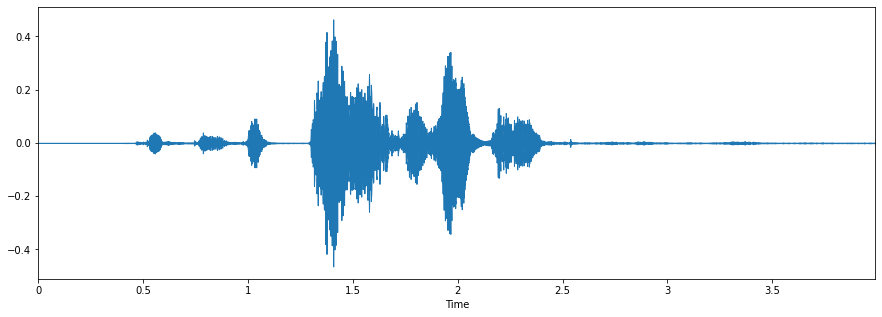

In [247]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [248]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [249]:
livedf2= pd.DataFrame(data=livedf2)

In [250]:
livedf2 = livedf2.stack().to_frame().T

In [251]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-26.610331,-27.10301,-24.850386,-26.353207,-24.672108,-22.974949,-23.919361,-26.08968,-27.105906,-27.986666,...,-32.758827,-32.456112,-32.943272,-34.728348,-32.771767,-33.798378,-35.708466,-35.573204,-33.807816,-33.468563


In [252]:
twodim= np.expand_dims(livedf2, axis=2)

In [253]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 14ms/step


In [254]:
livepreds

array([[2.3900069e-05, 2.1082341e-11, 1.2405534e-12, 7.5382733e-05,
        2.4995311e-06, 3.7066077e-03, 1.4354201e-06, 9.7793394e-01,
        1.4628914e-02, 3.6272695e-03]], dtype=float32)

In [255]:
livepreds1=livepreds.argmax(axis=1)

In [256]:
liveabc = livepreds1.astype(int).flatten()

In [257]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype=object)